In [18]:
!sudo pip install poetry
!sudo poetry config virtualenvs.create false --local
!sudo poetry install --no-root

Skipping virtualenv creation, as specified in config file.
Installing dependencies from lock file

No dependencies to install or update


In [19]:
##%%
import os
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Parameters
USE_PRETRAINED_MODEL = False
# MODEL_PATH = "/content/sign_language_99_cnn."
MODEL_PATH = "./sign_language_99_cnn.pth"
Learning_Rate = 0.01
Epochs = 100
confused = np.zeros((26, 26))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device)
print("Setup complete.")


Setup complete.


In [21]:

label_list = [chr(i) for i in range(65, 91)]

In [22]:
import os
import zipfile
import requests

DATA_URL = "https://www.kaggle.com/api/v1/datasets/download/datamunge/sign-language-mnist"
ZIP_NAME = "sign-language-mnist.zip"
CSV_FILES = ["sign_mnist_train.csv", "sign_mnist_test.csv"]

def download_and_extract():
    print("Downloading dataset...")
    with requests.get(DATA_URL, stream=True) as r:
        r.raise_for_status()
        with open(ZIP_NAME, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

    print("Extracting dataset...")
    with zipfile.ZipFile(ZIP_NAME, 'r') as zip_ref:
        zip_ref.extractall()

# Check for CSVs and download/extract if needed
if not all(os.path.exists(csv) for csv in CSV_FILES):
    download_and_extract()
else:
    print("CSV files already present.")

CSV files already present.


In [23]:
# This helps speed up data loading time across multiple runs (pkl > csv)
def preprocess_and_save(csv_path, pkl_path):
    df = pd.read_csv(csv_path)
    labels = df.iloc[:, 0].astype(np.int64).values
    images = df.iloc[:, 1:].astype(np.float32).values / 255.0
    images = images.reshape((-1, 1, 28, 28))

    with open(pkl_path, 'wb') as f:
        pickle.dump((images, labels), f)
    print(f"Saved to {pkl_path}")



preprocess_and_save("sign_mnist_train/sign_mnist_train.csv", "train.pkl")
preprocess_and_save("sign_mnist_test/sign_mnist_test.csv", "test.pkl")

Saved to train.pkl
Saved to test.pkl


In [24]:
##%%
class MNIST_Pickle_Dataset(Dataset):
    def __init__(self, pkl_file):
        with open(pkl_file, 'rb') as f:
            self.images, self.labels = pickle.load(f)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.images[idx]), torch.tensor(self.labels[idx])

train_Data = MNIST_Pickle_Dataset("train.pkl")
test_Data = MNIST_Pickle_Dataset("test.pkl")

loaders = {
    'train': DataLoader(train_Data, batch_size=32, shuffle=True),
    'test': DataLoader(test_Data, batch_size=32, shuffle=False),
}


In [25]:
# The Architecture
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layers + BatchNorm
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout2d = nn.Dropout2d(0.2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Adaptive Global Average Pooling to (1,1)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 26)  # 26 classes for A-Z

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2d(x)

        x = self.pool2(F.relu(self.bn3(self.conv3(x))))
        x = self.gap(x)
        x = x.view(x.size(0), -1)  # Flatten

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # No log_softmax here!

        return x  # Will use CrossEntropyLoss externally

# Setup model, optimizer, loss
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=Learning_Rate)
loss_fn = nn.CrossEntropyLoss()

# # Optional scheduler to reduce LR on plateaus
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=4, factor=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 80], gamma=0.1)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
# scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)




In [26]:
# For saving the model & Resusing it
def save_model():
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, MODEL_PATH)
    print(f"Model saved to {MODEL_PATH}")

def load_model():
    if os.path.exists(MODEL_PATH):
        checkpoint = torch.load(MODEL_PATH, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print("Model loaded.")
    else:
        print("No saved model found.")

if USE_PRETRAINED_MODEL:
    load_model()


In [27]:
# Training and Testing procedures
def train(epoch):
    model.train()
    total_loss = 0
    for data, target in loaders['train']:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loaders['train'])

def test():
    global confused
    model.eval()
    test_loss = 0
    correct = 0
    confused.fill(0)

    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1)
            for t, p in zip(target.cpu().numpy(), pred.cpu().numpy()):
                confused[t, p] += 1
            correct += (pred == target).sum().item()

    test_loss /= len(loaders['test'])
    accuracy = correct / len(loaders['test'].dataset)
    print(f"Test: Avg loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders['test'].dataset)} ({accuracy*100:.2f}%)")
    return accuracy


In [28]:
# Plot Setup
import matplotlib.pyplot as plt

train_losses = []
test_accuracies = []

def record_metrics(train_loss, test_accuracy):
    train_losses.append(train_loss)
    test_accuracies.append(test_accuracy)


In [ ]:
if not USE_PRETRAINED_MODEL:
    for epoch in range(Epochs):
        train_loss = train(epoch)
        test_accuracy = test()

        record_metrics(train_loss, test_accuracy)
        scheduler.step(test_accuracy)


        if test_accuracy >= 99.8:
            print(f" Early stopping: Reached {test_accuracy:.2f}% accuracy at epoch {epoch + 1}")
            break

    save_model()
else:
    test()


Test: Avg loss: 1.7087, Accuracy: 2675/7172 (37.30%)


/usr/local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Test: Avg loss: 0.9205, Accuracy: 4651/7172 (64.85%)
Test: Avg loss: 0.4553, Accuracy: 6219/7172 (86.71%)
Test: Avg loss: 2.4234, Accuracy: 3374/7172 (47.04%)
Test: Avg loss: 0.1905, Accuracy: 6768/7172 (94.37%)
Test: Avg loss: 0.2474, Accuracy: 6546/7172 (91.27%)
Test: Avg loss: 0.0829, Accuracy: 7043/7172 (98.20%)


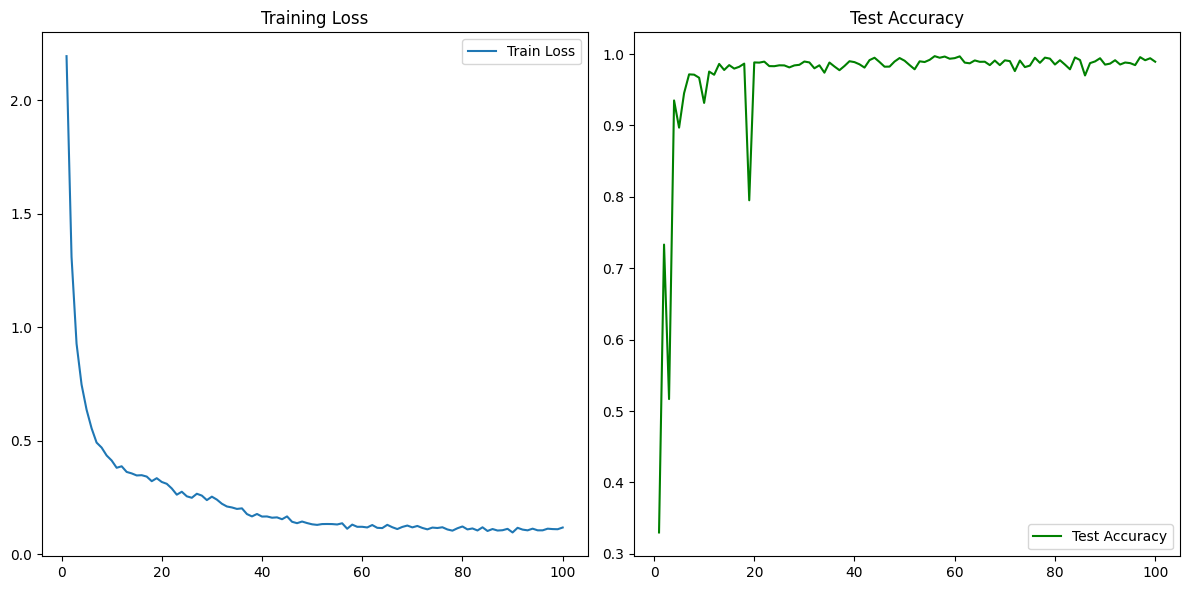

In [ ]:

# Plot after training
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(test_accuracies)+1), test_accuracies, label='Test Accuracy', color='green')
plt.title("Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

<ipython-input-108-39ee8bc7b058>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


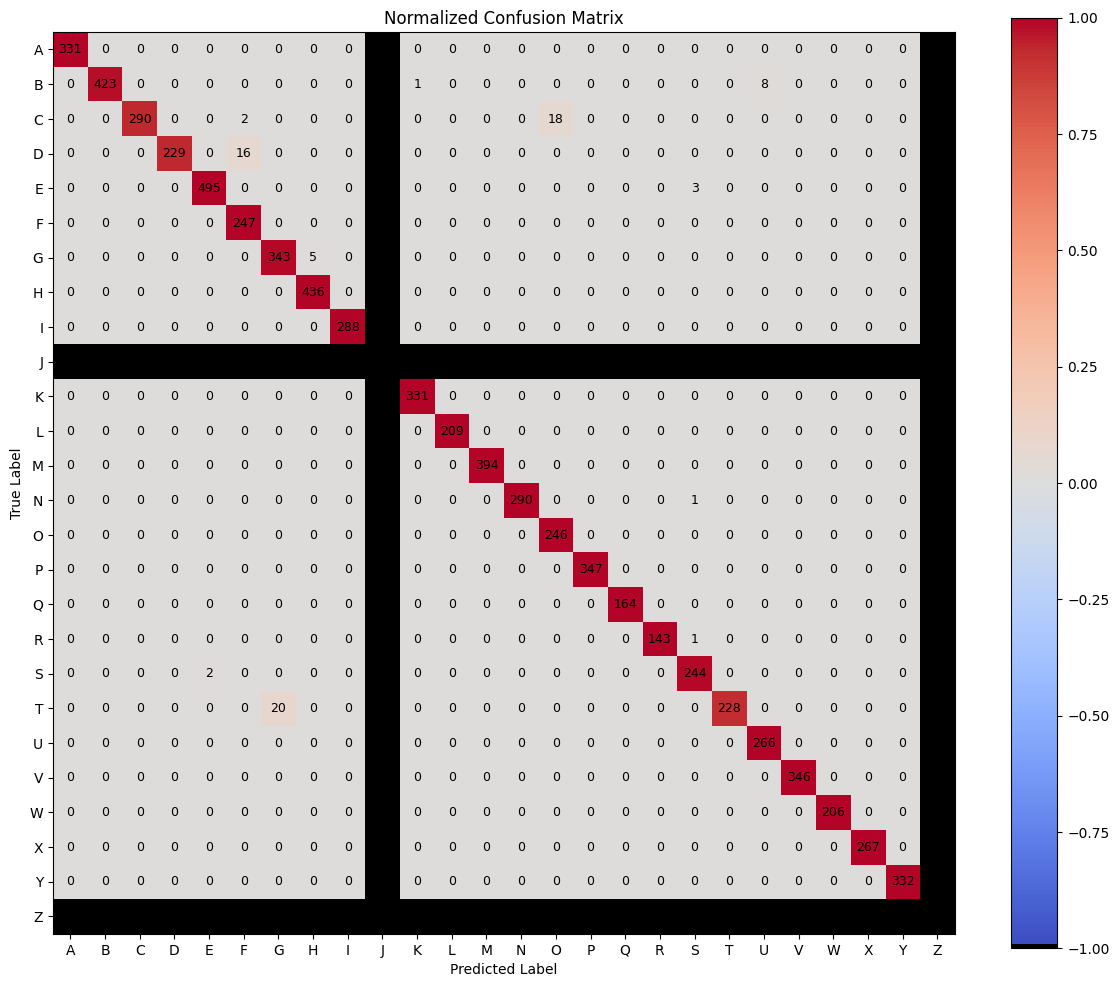

In [ ]:

excluded_labels = ['J', 'Z']
excluded_indices = [label_list.index(l) for l in excluded_labels]

normalized_confusion = confused.astype(np.float32)
row_sums = normalized_confusion.sum(axis=1, keepdims=True)
normalized_confusion = np.divide(normalized_confusion, row_sums, out=np.zeros_like(normalized_confusion), where=row_sums != 0)

# black out excluded rows/cols visually
mask = np.ones_like(normalized_confusion)
for idx in excluded_indices:
    mask[idx, :] = 0
    mask[:, idx] = 0


display_matrix = np.where(mask == 1, normalized_confusion, -1)

plt.figure(figsize=(12, 10))

# Custom colormap with black for excluded
from matplotlib import cm
from matplotlib.colors import ListedColormap
cmap = cm.get_cmap('coolwarm')
new_colors = cmap(np.linspace(0, 1, 256))
new_colors[0] = [0, 0, 0, 1]  # RGBa for black
custom_cmap = ListedColormap(new_colors)

plt.imshow(display_matrix, interpolation='nearest', cmap=custom_cmap, vmin=-1, vmax=1)
plt.title('Normalized Confusion Matrix')
plt.colorbar()

# Draw text only where not excluded
for i in range(26):
    for j in range(26):
        if i in excluded_indices or j in excluded_indices:
            continue
        count = confused[i, j]
        if count >= 0:
            plt.text(j, i, f'{int(count)}', ha='center', va='center', color='black', fontsize=9)

plt.xticks(np.arange(26), label_list)
plt.yticks(np.arange(26), label_list)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


In [ ]:
from PIL import Image

#  crop boxes for letters(left, upper, right, lower)
hardcoded_boxes = [
    (9, 9, 99, 99),        # A
    (119, 9, 209, 99),     # B
    (229, 9, 319, 99),     # C
    (339, 9, 429, 99),     # D
    (449, 9, 539, 99),     # E
    (559, 9, 649, 99),     # F

    (9, 124, 99, 214),     # G
    (119, 124, 209, 214),  # H
    (229, 124, 319, 214),  # I
    # (339, 124, 429, 214),  # J
    (449-90-20, 124, 539-90-20, 214),  # K
    (559-90-20, 124, 649-90-20, 214),  # L

    (9, 239, 99, 329),     # M
    (119-90-20, 239, 209-90-20, 329),  # N
    (229-90-20, 239, 319-90-20, 329),  # O
    (339-90-20, 239, 429-90-20, 329),  # P
    (449-90-20, 239, 539-90-20, 329),  # Q
    (559-90-20, 239, 649-90-20, 329),  # R

    (9+90*6, 354-90-25, 99+90*6, 444+-90-25),     # S
    (119-90-20, 354, 209-90-20, 444),  # T
    (229-90-20, 354, 319-90-20, 444),  # U
    (339-90-20, 354, 429-90-20, 444),  # V
    (449-90-20, 354, 539-90-20, 444),  # W
    (559-90-20, 354, 649-90-20, 444),  # X

    (665-6-90, 471-6-90-20, 665-6,471-20),       # Y
    (665-6-90, 471-6-90-20, 665-6,471-20)      # Z
]

label_list = [chr(i) for i in range(ord('A'), ord('Z') + 1)]  # ['A', ..., 'Z']


large_image_path="/content/amer_sign2.png"
def get_cropped_image(label):
    label_index = label_list.index(label)
    box = hardcoded_boxes[label_index]

    large_image = Image.open(large_image_path)
    cropped_image = large_image.crop(box)
    return cropped_image

def get_misclassified_indexes(target_label='B'):
    model.eval()
    misclassified = []

    target_index = label_list.index(target_label)

    for idx, (data, target) in enumerate(test_Data):
        if target.item() != target_index:
            continue  # Only check samples with target label == target_label

        data = data.unsqueeze(0).to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)

        if pred.item() != target_index:
            misclassified.append(idx)

    return misclassified



# Function to display multiple test images and their cropped reference images
def display_images(indexes):
    counter =0
    for index in indexes:
        model.eval()
        data, target = test_Data[index]
        data = data.unsqueeze(0).to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        image = data.squeeze().cpu().numpy()

        true_label = label_list[target.item()]
        pred_label = label_list[pred.item()]

        # Decide how many images to show based on whether prediction was wrong
        show_pred_ref = pred_label != true_label
        num_cols = 3 if show_pred_ref else 2

        plt.figure(figsize=(4 * num_cols, 4))

        # Test image
        plt.subplot(1, num_cols, 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'True: {true_label} | Pred: {pred_label}')
        plt.axis('off')

        # True label ref image
        cropped_true = get_cropped_image(true_label)
        plt.subplot(1, num_cols, 2)
        plt.imshow(cropped_true)
        plt.title(f'True Label: {true_label}')
        plt.axis('off')

        # Predicted label ref image (only if different)
        if show_pred_ref:
            cropped_pred = get_cropped_image(pred_label)
            plt.subplot(1, num_cols, 3)
            plt.imshow(cropped_pred)
            plt.title(f'Predicted Label: {pred_label}')
            plt.axis('off')

        counter+=1
        plt.tight_layout()
        plt.show()
    print(counter)

In [ ]:
import random

def generate_random_indexes(N):
    return random.sample(range(7170), N)


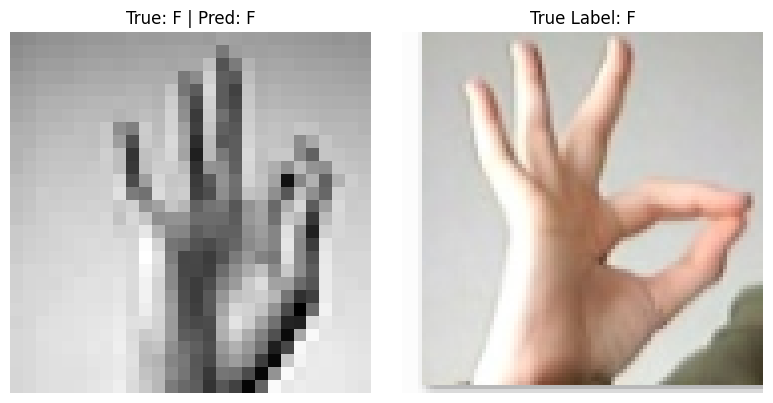

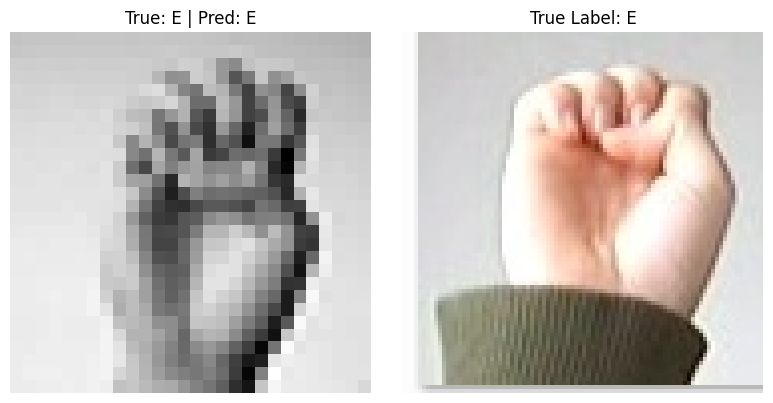

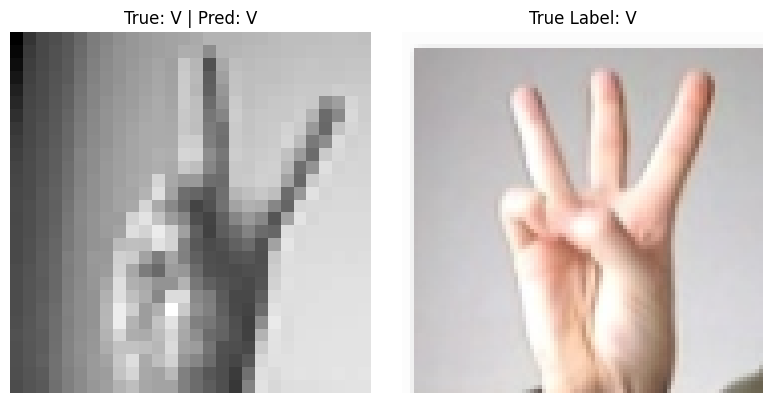

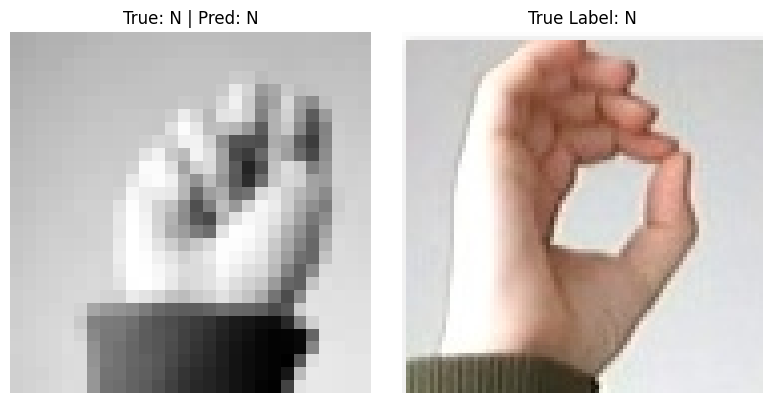

4


In [ ]:
# indexes_to_test = generate_random_indexes(7170)
indexes_to_test = [1,15,7000,61]

# indexes_to_test=get_misclassified_indexes('E')

display_images(indexes_to_test)